# Revisão: Redes Neurais com PyTorch e `torch.nn`

Este notebook serve como uma revisão concisa do processo de construção e treinamento de uma rede neural para classificação de imagens usando a interface de alto nível do PyTorch. O objetivo é recapitular os componentes essenciais, assumindo familiaridade prévia com os conceitos.

## Tópicos Abordados

1.  **Datasets e DataLoaders**: Carregamento eficiente de dados.
2.  **Definição do Modelo com `nn.Module`**: Estruturando a rede neural.
3.  **Função de Custo e Otimizador**: Os componentes do aprendizado.
4.  **Loop de Treinamento Completo**: O ciclo de treino e validação.

## 1. Datasets e DataLoaders

O primeiro passo em qualquer pipeline de machine learning é o carregamento de dados. A biblioteca `torchvision` oferece acesso direto a datasets clássicos, como o MNIST. Para alimentar o modelo de forma eficiente, envolvemos o `Dataset` em um `DataLoader`, que automatiza a criação de lotes (*batches*), o embaralhamento dos dados e o carregamento em paralelo.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Definindo transformações para normalizar os dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Média e desvio padrão do MNIST
])

# Baixando os datasets de treino e teste
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.31MB/s]


In [2]:
# Criando os DataLoaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Verificando as dimensões de um lote
images, labels = next(iter(train_loader))
print(f"Formato do batch de imagens: {images.shape}")
print(f"Formato do batch de rótulos: {labels.shape}")

Formato do batch de imagens: torch.Size([128, 1, 28, 28])
Formato do batch de rótulos: torch.Size([128])


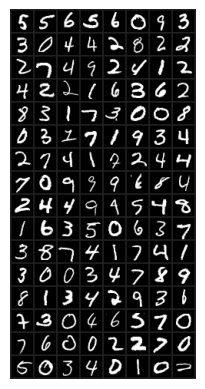

Rótulos:  5 5 6 5 6 0 9 3 3 0 4 4 2 8 2 2 2 7 4 9 2 4 1 2 4 2 2 1 6 3 6 2 8 3 1 7 3 0 0 8 0 3 1 7 1 9 3 4 2 7 4 1 7 2 4 4 7 0 9 9 9 6 8 4 2 4 4 9 4 5 4 8 1 6 3 5 0 6 3 7 3 8 7 4 1 7 4 1 3 0 0 3 4 7 8 9 8 1 3 4 2 9 3 6 7 3 0 4 6 5 7 0 7 6 0 0 2 2 7 0 5 0 3 4 0 1 0 2


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Função para exibir uma imagem
def imshow(img):
    # A normalização precisa ser revertida para a visualização correta
    # Média = 0.1307, Desvio Padrão = 0.3081
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # Remove os eixos
    plt.show()

# Pega um lote (batch) de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostra as imagens em uma grade
# O make_grid organiza o lote de imagens em uma única imagem-grade
imshow(torchvision.utils.make_grid(images))

# Imprime os rótulos correspondentes
print('Rótulos: ', ' '.join(f'{labels[j].item()}' for j in range(batch_size)))

## 2. Definição do Modelo com `nn.Module`

Uma rede neural é uma coleção de parâmetros aprendíveis (pesos e biases) organizados em camadas. Em PyTorch, qualquer modelo customizado é definido como uma classe que herda de `torch.nn.Module`.

A camada fundamental para redes neurais densas (ou totalmente conectadas) é a `nn.Linear`, que aplica a transformação afim $y = xW^T + b$. A combinação de camadas lineares com funções de ativação não lineares, como a `ReLU`, permite que a rede aprenda relações complexas nos dados.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # O 'forward pass' define como os dados fluem através das camadas
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# Instanciando o modelo
input_size = 28 * 28 # Imagens MNIST são 28x28
hidden_size = 256
num_classes = 10

model = NeuralNetwork(input_size, hidden_size, num_classes)
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 3. Função de Custo e Otimizador

Para treinar a rede, precisamos de dois componentes-chave:

1.  **Função de Custo (Loss Function)**: Mede a discrepância entre as previsões do modelo e os rótulos verdadeiros. Para classificação multiclasse, a `nn.CrossEntropyLoss` é a escolha padrão, pois combina `LogSoftmax` e `NLLLoss` de forma numericamente estável.

2.  **Otimizador (Optimizer)**: Implementa um algoritmo (como Adam ou SGD) que atualiza os pesos do modelo na direção que minimiza a função de custo, com base nos gradientes calculados.

In [5]:
import torch.optim as optim

# Definindo a função de custo
criterion = nn.CrossEntropyLoss()

# Definindo o otimizador
# Passamos os parâmetros do modelo que ele deve otimizar
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 4. Loop de Treinamento Completo

O treinamento consiste em iterar sobre o dataset por várias épocas. Em cada iteração (sobre um lote de dados), o processo é sempre o mesmo:

1.  Zerar os gradientes acumulados (`optimizer.zero_grad()`).
2.  Realizar o *forward pass*: passar os dados pelo modelo para obter as previsões.
3.  Calcular a perda (custo) comparando as previsões com os rótulos.
4.  Realizar o *backward pass*: calcular os gradientes da perda em relação a cada parâmetro (`loss.backward()`).
5.  Atualizar os pesos do modelo (`optimizer.step()`).

Após cada época de treino, é uma boa prática avaliar o desempenho do modelo no conjunto de validação/teste, lembrando de usar o contexto `torch.no_grad()` para desativar o cálculo de gradientes e acelerar a computação.

In [6]:
from tqdm.notebook import tqdm

# Configurações do treinamento
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Treinando no dispositivo: {device}")

for epoch in range(num_epochs):
    # --- Fase de Treinamento ---
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs} [Treino]')

    for images, labels in progress_bar:
        # Achatando as imagens de [batch_size, 1, 28, 28] para [batch_size, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # 1. Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 2. Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        progress_bar.set_postfix({'Perda Treino': f'{loss.item():.4f}'})

    # --- Fase de Validação ---
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Fim da Época {epoch+1}: Perda Média de Treino: {train_loss / len(train_loader):.4f}, Acurácia no Teste: {accuracy:.2f}%')

print("Treinamento concluído!")

Treinando no dispositivo: cpu


Época 1/5 [Treino]:   0%|          | 0/469 [00:00<?, ?it/s]

Fim da Época 1: Perda Média de Treino: 0.2637, Acurácia no Teste: 95.86%


Época 2/5 [Treino]:   0%|          | 0/469 [00:00<?, ?it/s]

Fim da Época 2: Perda Média de Treino: 0.1078, Acurácia no Teste: 97.18%


Época 3/5 [Treino]:   0%|          | 0/469 [00:00<?, ?it/s]

Fim da Época 3: Perda Média de Treino: 0.0709, Acurácia no Teste: 97.45%


Época 4/5 [Treino]:   0%|          | 0/469 [00:00<?, ?it/s]

Fim da Época 4: Perda Média de Treino: 0.0537, Acurácia no Teste: 97.86%


Época 5/5 [Treino]:   0%|          | 0/469 [00:00<?, ?it/s]

Fim da Época 5: Perda Média de Treino: 0.0399, Acurácia no Teste: 97.76%
Treinamento concluído!


## 5. Inferência com o Modelo Treinado

Após o treinamento, o modelo está pronto para ser usado para fazer previsões em dados que nunca viu. O processo de inferência consiste em pegar uma ou mais amostras de dados, passá-las pelo modelo no modo de avaliação (`model.eval()`) e interpretar a saída para obter a predição final.

Para um modelo de classificação, a saída do modelo são os *logits* (pontuações brutas) para cada classe. A classe com o maior logit é a predição do modelo. Vamos visualizar algumas previsões no conjunto de teste para ver nosso modelo em ação.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Coloca o modelo em modo de avaliação
model.eval()

# Pega um lote de dados do conjunto de teste
images, labels = next(iter(test_loader))

# Move os dados para o mesmo dispositivo do modelo
images_to_show = images.to(device)
labels_to_show = labels.to(device)

# Faz a inferência
with torch.no_grad():
    # Achatamos a imagem para o formato esperado pelo modelo
    outputs = model(images_to_show.reshape(-1, 28*28))

# Obtém as classes previstas pegando o índice do maior logit
_, predicted_labels = torch.max(outputs, 1)

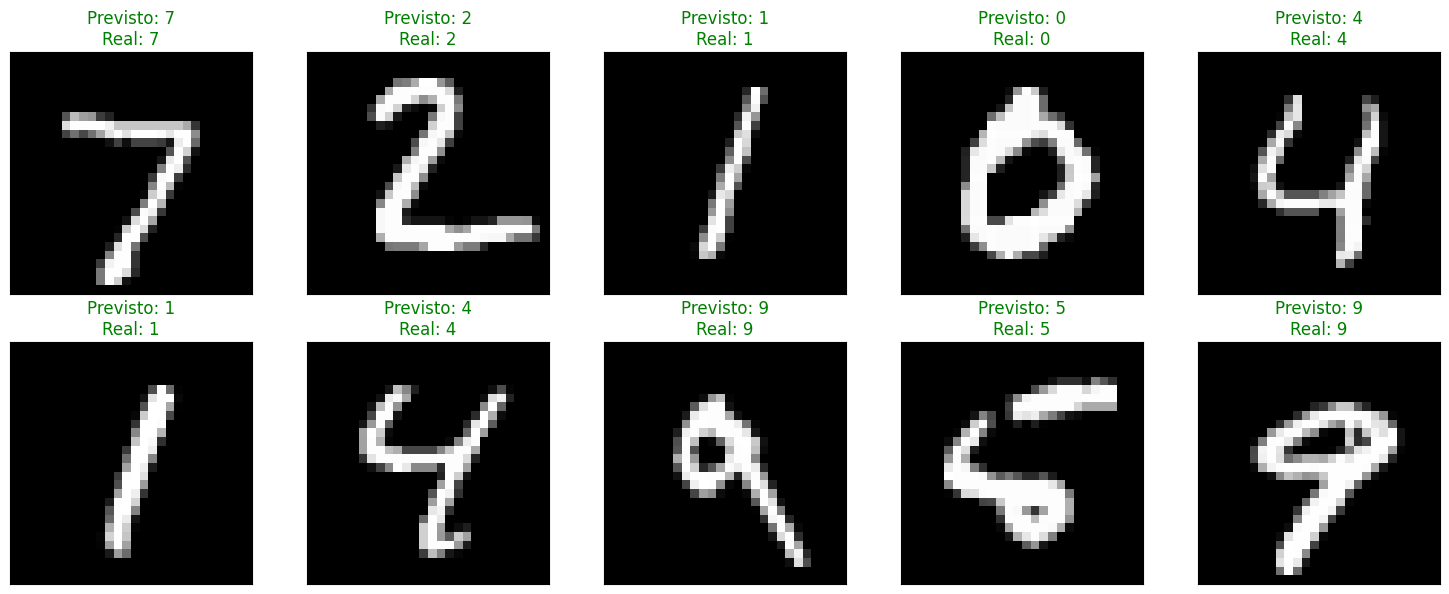

In [8]:
# Visualizando as previsões
fig = plt.figure(figsize=(15, 6))
for i in range(10): # Visualizar 10 imagens
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])

    # Move a imagem de volta para a CPU para visualização com matplotlib
    img = images[i].cpu()

    # Desnormaliza a imagem para exibição (opcional, mas melhora visualização)
    img = img * 0.3081 + 0.1307

    plt.imshow(img.squeeze(), cmap='gray') # .squeeze() para remover dimensão de cor

    pred = predicted_labels[i].item()
    true_label = labels_to_show[i].item()

    # Define a cor do título com base se a previsão está correta
    color = "green" if pred == true_label else "red"

    ax.set_title(f"Previsto: {pred}\nReal: {true_label}", color=color)

plt.tight_layout()
plt.show()